In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Hyperparameters and Model Validation

Basic recipe;

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use th model to predict labels for new data

So, how do we choose a class of model and then it's hyperparameters?

### Model Validation Holdout Sets

A **holdout set** is a subset of the training data that is not used to train the model. This set is then used to check the model performance. It can done using the train_test_split utility in Scikit-Learn

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.90666666666666662

The model is 90% accurate on the holdout set.

### Model Validation Cross-Validation

The downside to the hold out method above is we lose out on using half our dataset to train the model.

During one round of **cross-validation** the data is split complementary subsets, the model is fit on one subset (called the training set), and then validated on the other subset, the model is then fit to the subset we initially used as the validation subset and validated on the original training set.

To reduce variability, in most methods multiple rounds of cross-validation are performed using different partitions, and the validation results are combined (e.g. averaged) over the rounds to estimate a final predictive model.

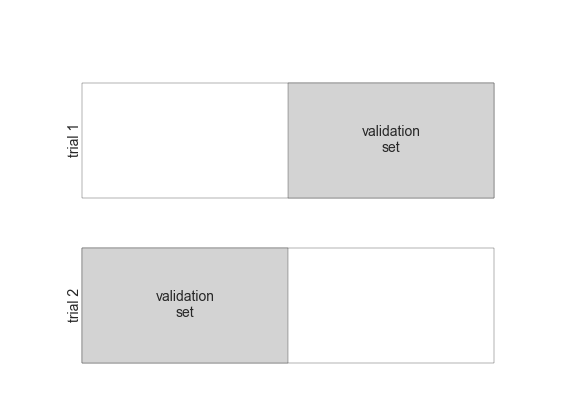

In [10]:
#two validation trials, alternately using each half of the data as a holdout set
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.95999999999999996, 0.90666666666666662)

In [11]:
#we can use the mean to get a measure of global model performance
(accuracy_score(y1, y1_model) + accuracy_score(y2, y2_model))/2

0.93333333333333335

This particular form of cross-validation is a *two-fold cross-validation* that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of *five-fold cross-validation*:

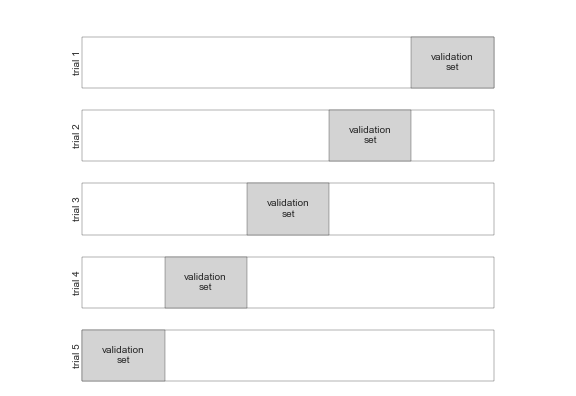

Instead of having to run the model line by line as we did above, Scikit-Learn has `cross_val_score`.

In [12]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5) #cv is number of folds

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

Scikit-Learn provides a number of cross validation tools. **Leave-one-out cross validation** is cheap to use(memory wise) and is essentially cross-validation with the number of folder equal to the number of data points. The model is trained on $n-1$ of the data points and then validated on the one left out point.

In [13]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [15]:
scores.mean()

0.95999999999999996

## Selecting the Best Model

**If our estimator is underperforming, how should we move forward?**

+ Use a more complicated/more flexible model
+ Use a less complicated/less flexible model
+ Gather more training samples
+ Gather more data to add features to each sample

What we are looking to do if find the sweet spot in the tradeoff between **bias** and **variance**.

**Variance** is the amount our model changes if estimated using a different training set. **Bias** refers to the error introduced by approximating a complex real-life problem with a simpler model.

As a general rule, as we use more flexible methods, the variance will increase and the bias will decrease.

Good test set performance of a statistical learning method requires low variance as well as low squared bias. This is referred to as a trade-off because it is easy to obtain a method with extremely low bias but high variance (for instance, by drawing a curve that passes through every single training observation) or a method with very low variance but high bias (by fitting a horizontal line to the data).

When a model does not have enough flexibility to account for all the features of the data, we say it **underfit** the data, this another way of saying the model has *high bias*.

If we have a model that essentially fits the training data perfect, it's form is probably reflective of noise in the data. This model is said to **overfit** the data, or it has *high variance*.

Below is the **validation curve**;

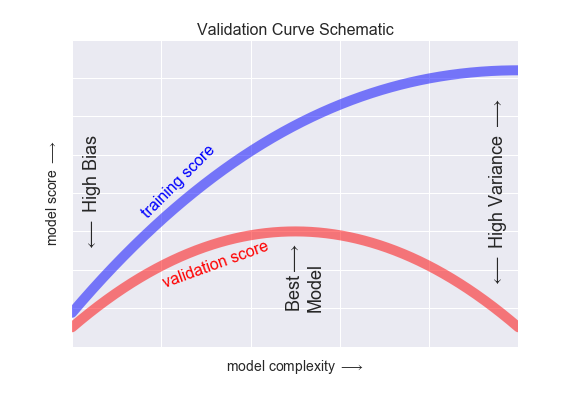

+ The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.

+ For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.

+ For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.

+ For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [18]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

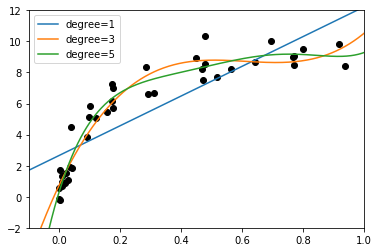

In [20]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The flexibility or complexity of the model is controlled by the degree of the polynomial. So, we want the degree that puts us in the sweet spot of the bian-variance trade-off.

Scikit-Learn provides a routine to visualize the validation curve. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range.

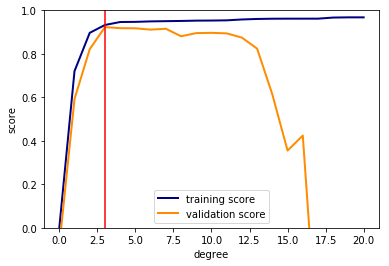

In [25]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='navy', label='training score', lw=2)
plt.plot(degree, np.median(val_score, 1), color='darkorange', label='validation score', lw=2)
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')
plt.axvline(3, c='r'); #max validation score is at polynomial of degree 3

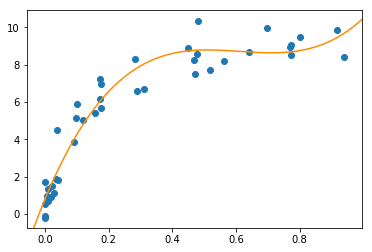

In [27]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, c='darkorange');
plt.axis(lim);

This is a relatively small amount of data, what if we increase it? With a larger dataset, we will see that a more complicated model can be fit, without overfitting. 

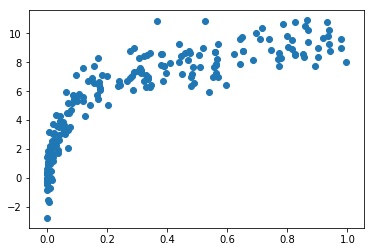

In [28]:
X2, y2 = make_data(200) #five times larger
plt.scatter(X2.ravel(), y2);

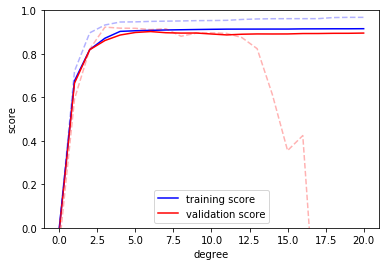

In [29]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

#plot validation curves for new larger dataset
plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')

#plot previous validation curves for smaller dataset
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')

plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This show the validation curve has two important inputs: the model complexity and the number of training points.

We can explore the model as a function of the size of the dataset by using increasingly larger subsets of the data to fit the model.

A plot of the training/validation score with respect to the size of the training set is known as a **learning curve**.

In general we expect;

+ A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.

+ A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.

+ A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

The *learning curve* is expected to look like this;

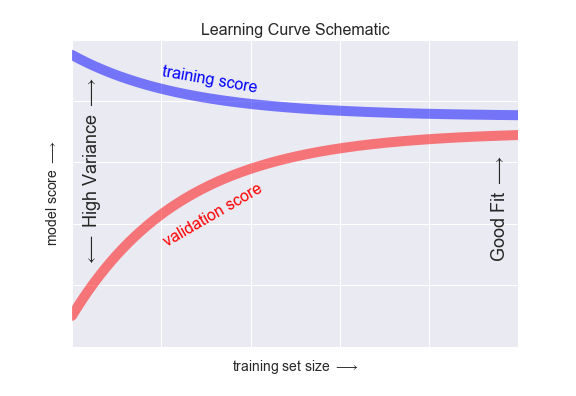

***Note:** once you have enough points that a particular model has converged, adding more training data will not help you! The only way to increase model performance in this case is to use another (often more complex) model.

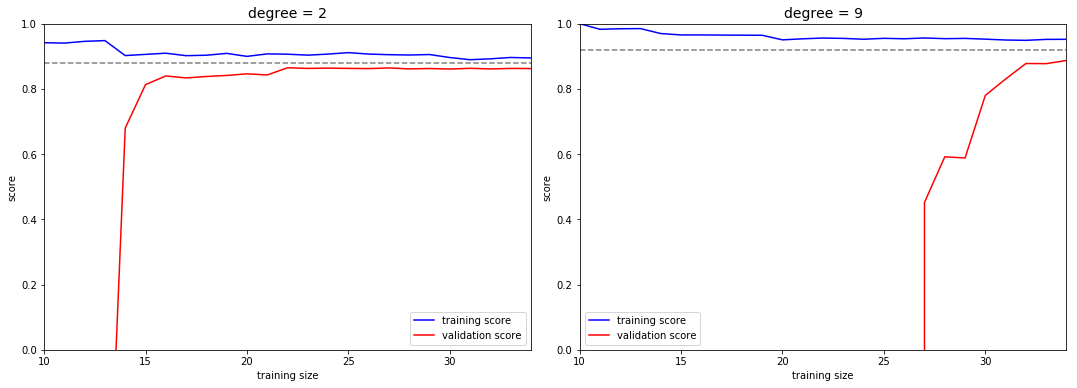

In [31]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

#N: Number of training examples, list of len 25, from set of 10 to 34

#train_lc, val_lc are lists of scores, len 25, each row contains the 7 accuracy 
#scores from the cv=7 for each training set size

#train_sizes=np.linspace(0.3, 1, 25) gives us 25 percents from 0.3 to 1
#use chose percent of X used as each training size


#np.mean(trial_lc/val_lc,1) is the mean of each row

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

On the degree 2 model we can see where the scores converge and that adding more data would not improve the score at convergence. The only way to do this is to move to a move complicated model, we can see the score is a little bit higher for the 9 degree polynomial and if we add more data points, it will eventually converge.

### Validation in Practice: Grid Search

In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces. In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

Below we use grid search through Scikit-Learn, we will use a polynomial regression  with three hypterparameter;

+ should we fit the intercept
+ should we normalize the problem
+ the polynomial degree

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7) #create grid object

In [61]:
grid.fit(X,y); #fit to data

In [62]:
grid.best_params_ #ask grid for the opitmal parameters

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

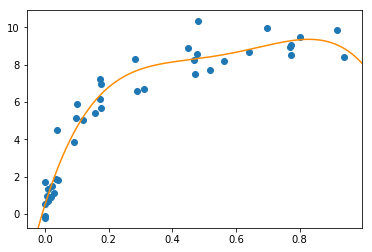

In [70]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, c='darkorange');
plt.axis(lim);

In [71]:
X_test.ravel?